In [ ]:


# !pip install tensorflow-privacy==0.7.3



In [2]:
#from __future__ import absolute_import, division, print_function

import sys
import logging
import math
import datetime
import random
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
#from tensorflow.keras.utils import to_categorical

#import tensorflow_privacy
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow_privacy.privacy.analysis.rdp_accountant import (
    compute_rdp,
    get_privacy_spent,
)
from tensorflow_privacy.privacy.optimizers import dp_optimizer
from tensorflow_privacy.privacy.optimizers.dp_optimizer_keras import DPKerasSGDOptimizer
import tensorflow_privacy.privacy.privacy_tests.membership_inference_attack.membership_inference_attack as mia
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack.data_structures import AttackInputData
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack.data_structures import SlicingSpec
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack.data_structures import AttackType

In [4]:
noise_multiplier=0.01
epochs=200
learning_rate=0.1


In [6]:
df = pd.read_csv("student-data/student-mat.csv",sep=";")
#df_stud_por = pd.read_csv("student-data/student-por.csv",sep=";")

In [7]:
pd.set_option('display.max_columns', 52)
df.select_dtypes(include='object')

,school,sex,address,famsize,Pstatus,Mjob,Fjob,reason,guardian,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic
0,GP,F,U,GT3,A,at_home,teacher,course,mother,yes,no,no,no,yes,yes,no,no
1,GP,F,U,GT3,T,at_home,other,course,father,no,yes,no,no,no,yes,yes,no
2,GP,F,U,LE3,T,at_home,other,other,mother,yes,no,yes,no,yes,yes,yes,no
3,GP,F,U,GT3,T,health,services,home,mother,no,yes,yes,yes,yes,yes,yes,yes
4,GP,F,U,GT3,T,other,other,home,father,no,yes,yes,no,yes,yes,no,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
390,MS,M,U,LE3,A,services,services,course,other,no,yes,yes,no,yes,yes,no,no
391,MS,M,U,LE3,T,services,services,course,mother,no,no,no,no,no,yes,yes,no
392,MS,M,R,GT3,T,other,other,course,other,no,no,no,no,no,yes,no,no
393,MS,M,R,LE3,T,services,other,course,mother,no,no,no,no,no,yes,yes,no


In [8]:
df_encode = pd.get_dummies(df)

In [9]:
df_encode.describe()

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3,school_GP,school_MS,sex_F,sex_M,address_R,address_U,famsize_GT3,famsize_LE3,Pstatus_A,Pstatus_T,...,Fjob_other,Fjob_services,Fjob_teacher,reason_course,reason_home,reason_other,reason_reputation,guardian_father,guardian_mother,guardian_other,schoolsup_no,schoolsup_yes,famsup_no,famsup_yes,paid_no,paid_yes,activities_no,activities_yes,nursery_no,nursery_yes,higher_no,higher_yes,internet_no,internet_yes,romantic_no,romantic_yes
count,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,...,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000
mean,16.696203,2.749367,2.521519,1.448101,2.035443,0.334177,3.944304,3.235443,3.108861,1.481013,2.291139,3.554430,5.708861,10.908861,10.713924,10.415190,0.883544,0.116456,0.526582,0.473418,0.222785,0.777215,0.711392,0.288608,0.103797,0.896203,...,0.549367,0.281013,0.073418,0.367089,0.275949,0.091139,0.265823,0.227848,0.691139,0.081013,0.870886,0.129114,0.387342,0.612658,0.541772,0.458228,0.491139,0.508861,0.205063,0.794937,0.050633,0.949367,0.167089,0.832911,0.665823,0.334177
std,1.276043,1.094735,1.088201,0.697505,0.839240,0.743651,0.896659,0.998862,1.113278,0.890741,1.287897,1.390303,8.003096,3.319195,3.761505,4.581443,0.321177,0.321177,0.499926,0.499926,0.416643,0.416643,0.453690,0.453690,0.305384,0.305384,...,0.498188,0.450064,0.261152,0.482622,0.447558,0.288172,0.442331,0.419976,0.462610,0.273201,0.335751,0.335751,0.487761,0.487761,0.498884,0.498884,0.500555,0.500555,0.404260,0.404260,0.219525,0.219525,0.373528,0.373528,0.472300,0.472300
min,15.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,16.000000,2.000000,2.000000,1.000000,1.000000,0.000000,4.000000,3.000000,2.000000,1.000000,1.000000,3.000000,0.000000,8.000000,9.000000,8.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000
50%,17.000000,3.000000,2.000000,1.000000,2.000000,0.000000,4.000000,3.000000,3.000000,1.000000,2.000000,4.000000,4.000000,11.000000,11.000000,11.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000
75%,18.000000,4.000000,3.000000,2.000000,2.000000,0.000000,5.000000,4.000000,4.000000,2.000000,3.000000,5.000000,8.000000,13.000000,13.000000,14.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,...,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000
max,22.000000,4

In [10]:
y=df_encode.G3
exclude_var=['G3']
print(exclude_var)
x_data=df_encode.drop(columns=exclude_var)

['G3']


In [11]:
y.value_counts()

10    56
11    47
0     38
15    33
8     32
13    31
12    31
9     28
14    27
16    16
6     15
18    12
7      9
5      7
17     6
19     5
20     1
4      1
Name: G3, dtype: int64

In [12]:
ybin = np.asarray(y)

In [13]:
print(ybin)

[ 6  6 10 15 10 15 11  6 19 15  9 12 14 11 16 14 14 10  5 10 15 15 16 12
  8  8 11 15 11 11 12 17 16 12 15  6 18 15 11 13 11 12 18 11  9  6 11 20
 14  7 13 13 10 11 13 10 15 15  9 16 11 11  9  9 10 15 12  6  8 16 15 10
  5 14 11 10 10 11 10  5 12 11  6 15 10  8  6 14 10  7  8 18  6 10 14 10
 15 10 14  8  5 17 14  6 18 11  8 18 13 16 19 10 13 19  9 16 14 13  8 13
 15 15 13 13  8 12 11  9  0 18  0  0 12 11  0  0  0  0 12 15  0  9 11 13
  0 11  0 11  0 10  0 14 10  0 12  8 13 10 15 12  0  7  0 10  7 12 10 16
  0 14  0 16 10  0  9  9 11  6  9 11  8 12 17  8 12 11 11 15  9 10 13  9
  8 10 14 15 16 10 18 10 16 10 10  6 11  9  7 13 10  7  8 13 14  8 10 15
  4  8  8 10  6  0 17 13 14  7 15 12  9 12 14 11  9 13  6 10 13 12 11  0
 12 12  0 12  0 18 13  8  5 15  8 10  8  8 12  8 13 11 14  0 18  8 12  9
  0 17 10 11 10  0  9 14 11 14 10 12  9  9  8 10  8 10 12 10 11 11 19 12
 14 15 11 15 13 18 14 11  0  8 14 16 11 10 14 18 13 12 18  8 12 10  0 13
 11 11 13 11  0  9 10 11 13  9 11 15 15 11 16 10  9

In [14]:
ybin[ybin<10] = 0
ybin[ybin>=10] = 1

In [18]:
# min-max normalization
x = (x_data - np.min(x_data)) / (np.max(x_data) - np.min(x_data)).values

In [19]:
x_train, x_test, y_train, y_test = train_test_split(x, ybin, test_size=0.2, random_state=0)

# get validation dataset
x_train, x_valid, y_train, y_valid = train_test_split(
    x_train, y_train, test_size=0.2, random_state=0
)

In [20]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((252, 58), (252,), (79, 58), (79,))

In [21]:
y_test

array([1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0,
       0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0,
       1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0], dtype=int64)

In [22]:
y_train

array([1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1,
       1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1,
       0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1,
       1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1,
       0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1,
       0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0,
       1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int64)

In [23]:
y_valid

array([0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1],
      dtype=int64)

In [24]:
len(x.columns)

58

In [25]:
training_size = x_train.shape[0]
training_size

252

In [26]:
# from here https://github.com/VectorInstitute/PETs-Bootcamp/blob/main/DP_TensorFlowPrivacy/TFP_HeartDisease_KerasMLP_GridSearch.ipynb
def train(
    noise_multiplier,
    l2_norm_clip,
    batch_size,
    microbatches,
    x_train,
    y_train,
    dpsgd=True,
    learning_rate=learning_rate,
    epochs=epochs,
    model_dir=None,
    print_outputs=True,
    verbose=1,
):

    if dpsgd and batch_size % microbatches != 0:
        raise ValueError("Number of microbatches should divide evenly batch_size")

    # Define a sequential Keras model
    model = tf.keras.Sequential(
        [
            tf.keras.layers.Dense(40, input_dim=58, activation="relu"),
            tf.keras.layers.Dense(60, activation="relu"),
            tf.keras.layers.Dense(20, activation="relu"),
            #tf.keras.layers.Dense(1, activation="sigmoid"),
            #V2 for mia attack we need logit output
            tf.keras.layers.Dense(1),
        ]
    )

    if dpsgd:
        optimizer = DPKerasSGDOptimizer(
            l2_norm_clip=l2_norm_clip,
            noise_multiplier=noise_multiplier,
            num_microbatches=microbatches,
            learning_rate=learning_rate,
        )
        # Compute vector of per-example loss rather than its mean over a minibatch.
        #loss = tf.keras.losses.BinaryCrossentropy(reduction=tf.losses.Reduction.NONE)
        loss = tf.keras.losses.BinaryCrossentropy(reduction=tf.losses.Reduction.NONE,from_logits=True) #V2

    else:
        optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
        #loss = tf.keras.losses.BinaryCrossentropy()
        loss = tf.keras.losses.BinaryCrossentropy(from_logits=True) #V2

    # F.MIA'S ATTACK USE THESE PARAMETERS
    '''
    # specify parameters
    optimizer = tf.keras.optimizers.Adam()
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

    # compile the model
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
    '''

    # Compile model with Keras
    model.compile(optimizer=optimizer, loss=loss, metrics=["accuracy"])


    display(model.summary())

    log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(
        log_dir=log_dir, histogram_freq=1
    )

    # Train model with Keras
    history=model.fit(
        x_train,
        y_train,
        epochs=epochs,
        validation_data=(x_valid, y_valid),
        batch_size=batch_size,
        verbose=verbose,
        callbacks=[tensorboard_callback],
    )

    # plot accuracy for the first model
    plt.plot(history.history['accuracy'], label='acc')
    plt.plot(history.history['val_accuracy'], label='val_acc')
    plt.legend();
    plt.ylim(0,1)

    score_train = model.evaluate(x_train, y_train, verbose=verbose)
    score_valid = model.evaluate(x_valid, y_valid, verbose=verbose)
    score_test = model.evaluate(x_test, y_test, verbose=verbose)

    weights = model.get_weights()

    # Compute the privacy budget expended.
    # // is integer division
    if dpsgd:
        eps = compute_epsilon(
            epochs * training_size // batch_size,
            training_size=training_size,
            noise_multiplier=noise_multiplier,
            batch_size=batch_size,
        )

    else:
        eps = "non-private SGD"

    if print_outputs:
        print(
            "\nhyperparamters: learning rate = "
            + str(learning_rate)
            + ", noise_multiplier = "
            + str(noise_multiplier)
            + ", l2_norm_clip = "
            + str(l2_norm_clip)
            + ", epochs = "
            + str(epochs)
            + ", batch_size = "
            + str(batch_size)
            + ", microbatches = "
            + str(microbatches)
        )

        print("  training loss: %.2f" % score_train[0])
        print("  training accuracy: %.2f" % score_train[1])

        print("  validation loss: %.2f" % score_valid[0])
        print("  validation accuracy: %.2f" % score_valid[1])

        print("  test loss: %.2f" % score_test[0])
        print("  test accuracy: %.2f" % score_test[1])
        
        Y_pred = model.predict(x_test)
        Y_pred = np.where(Y_pred > 0.5, 1,0)#np.argmax(Y_pred,axis=1)
        print(classification_report(y_test, Y_pred))   

        if dpsgd:
            print("For delta=0.00413223, the current epsilon is: %.2f" % eps)
        else:
            print("Trained with vanilla non-private SGD optimizer")

    return ((score_train, score_valid, score_test, eps, weights, Y_pred),model)

In [27]:
def compute_epsilon(steps, training_size, noise_multiplier, batch_size):
    """
    Computes epsilon value for given hyperparameters.

    Parameters required:
      steps: Number of steps the optimizer takes over the training data
             steps = FLAGS.epochs * training_size// FLAGS.batch_size

      Noise multiplier:
          the amount of noise sampled and added to gradients during training
    """
    if noise_multiplier == 0.0:
        return float("inf")

    """ 
  Delta: for (epsilon, delta)-DP
    Delta bounds the probability of our privacy guarantee not holding.  
    rule of thumb for delta is to set it to less than the inverse of the training data size
    so I opted for it to equal to 1.1*training size
  """
    training_delta = 1 / (training_size * 1.1)

    """
  We need to define a list of orders, at which the Rényi divergence will be computed
  if you want epsilon between 1-10 and your delta is fixed
  your orders must cover the range between 1+ln(1/delta)/10 and 1+ln(1/delta)/1 
  """
    orders = np.linspace(
        1 + math.log(1.0 / training_delta) / 10,
        1 + math.log(1.0 / training_delta) / 1,
        num=100,
    )

    """ 
  Sampling ratio q:
    the probability of an individual training point being included in a minibatch
    sampling_probability = FLAGS.batch_size / training_size
  """
    sampling_probability = batch_size / training_size

    """ 
  compute Renyi Differential Privacy, a generalization of pure differential privacy
  RDP is well suited to analyze DP guarantees provided by sampling followed by Gaussian noise addition, 
  which is how gradients are randomized in the TFP implementation of the DP-SGD optimizer.
  """
    rdp = compute_rdp(
        q=sampling_probability,
        noise_multiplier=noise_multiplier,
        steps=steps,
        orders=orders,
    )

    return get_privacy_spent(orders, rdp, target_delta=training_delta)[0]

## Train model

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 40)                2360      
                                                                 
 dense_1 (Dense)             (None, 60)                2460      
                                                                 
 dense_2 (Dense)             (None, 20)                1220      
                                                                 
 dense_3 (Dense)             (None, 1)                 21        
                                                                 
Total params: 6,061
Trainable params: 6,061
Non-trainable params: 0
_________________________________________________________________


None

Epoch 1/200
12/12 [==============================] - 1s 32ms/step - loss: 0.6941 - accuracy: 0.3254 - val_loss: 0.6757 - val_accuracy: 0.2812
Epoch 2/200
12/12 [==============================] - 0s 8ms/step - loss: 0.6574 - accuracy: 0.3452 - val_loss: 0.6390 - val_accuracy: 0.2969
Epoch 3/200
12/12 [==============================] - 0s 9ms/step - loss: 0.6358 - accuracy: 0.4127 - val_loss: 0.6167 - val_accuracy: 0.4688
Epoch 4/200
12/12 [==============================] - 0s 8ms/step - loss: 0.6239 - accuracy: 0.5516 - val_loss: 0.6035 - val_accuracy: 0.5938
Epoch 5/200
12/12 [==============================] - 0s 7ms/step - loss: 0.6161 - accuracy: 0.6230 - val_loss: 0.5957 - val_accuracy: 0.6562
Epoch 6/200
12/12 [==============================] - 0s 9ms/step - loss: 0.6109 - accuracy: 0.6587 - val_loss: 0.5896 - val_accuracy: 0.6719
Epoch 7/200
12/12 [==============================] - 0s 7ms/step - loss: 0.6074 - accuracy: 0.6825 - val_loss: 0.5864 - val_accuracy: 0.7031
Epoch 8/200


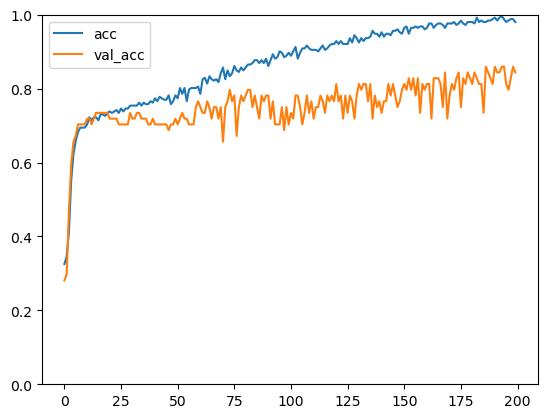

In [28]:
(training_outputs,model) = train(
    noise_multiplier=noise_multiplier,
    l2_norm_clip=1,
    batch_size=22,
    microbatches=11,
    x_train=x_train,
    y_train=y_train,
    dpsgd=False,
    learning_rate=0.01,
    epochs=200,
    model_dir=None,
    print_outputs=True,
)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 40)                2360      
                                                                 
 dense_5 (Dense)             (None, 60)                2460      
                                                                 
 dense_6 (Dense)             (None, 20)                1220      
                                                                 
 dense_7 (Dense)             (None, 1)                 21        
                                                                 
Total params: 6,061
Trainable params: 6,061
Non-trainable params: 0
_________________________________________________________________


None

Epoch 1/200
12/12 [==============================] - 2s 18ms/step - loss: 0.6734 - accuracy: 0.3571 - val_loss: 0.6479 - val_accuracy: 0.2969
Epoch 2/200
12/12 [==============================] - 0s 8ms/step - loss: 0.6457 - accuracy: 0.4087 - val_loss: 0.6211 - val_accuracy: 0.4844
Epoch 3/200
12/12 [==============================] - 0s 8ms/step - loss: 0.6314 - accuracy: 0.5714 - val_loss: 0.6131 - val_accuracy: 0.5781
Epoch 4/200
12/12 [==============================] - 0s 9ms/step - loss: 0.6249 - accuracy: 0.6032 - val_loss: 0.6099 - val_accuracy: 0.6250
Epoch 5/200
12/12 [==============================] - 0s 10ms/step - loss: 0.6271 - accuracy: 0.6468 - val_loss: 0.6052 - val_accuracy: 0.6562
Epoch 6/200
12/12 [==============================] - 0s 10ms/step - loss: 0.6232 - accuracy: 0.6429 - val_loss: 0.6039 - val_accuracy: 0.6406
Epoch 7/200
12/12 [==============================] - 0s 11ms/step - loss: 0.6192 - accuracy: 0.6587 - val_loss: 0.6041 - val_accuracy: 0.6406
Epoch 8/2

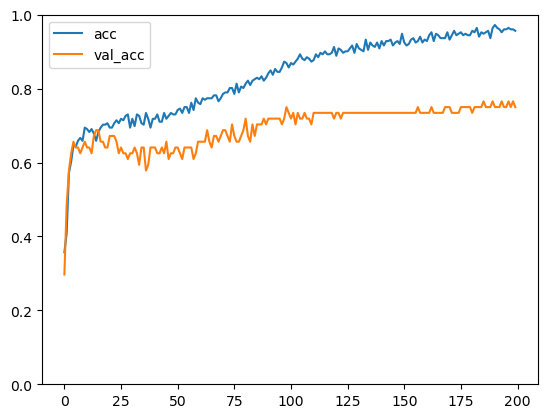

In [29]:
# dpsgd model
training_outputs = train(
    noise_multiplier=noise_multiplier,
    l2_norm_clip=1,
    batch_size=22,
    microbatches=1,
    x_train=x_train,
    y_train=y_train,
    dpsgd=True,
    learning_rate=0.01,
    epochs=epochs,
    #epochs=200,
    model_dir=None,
    print_outputs=True,
)

![image.png](attachment:28f51ce6-7447-473d-81b0-524b19486a42.png)
![image.png](attachment:d2ccc47d-6b01-4c9f-9356-b171ad155205.png)

In [30]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape
# since we have not specified an activation function on the last layer
# calling the predict function returns the logits
print('Predict on train...')
logits_train = model.predict(x_train)
print('Predict on test...')
logits_test = model.predict(x_test)

print('Apply softmax to get probabilities from logits...')
prob_train = tf.nn.sigmoid(np.array(logits_train).flatten())
prob_test = tf.nn.sigmoid(np.array(logits_test).flatten())

print('Compute losses...')
#cce = tf.keras.backend.categorical_crossentropy
bce = tf.keras.backend.binary_crossentropy
constant = tf.keras.backend.constant

#y_train_onehot = tf.keras.utils.to_categorical(y_train)
#y_test_onehot = tf.keras.utils.to_categorical(y_test)


Predict on train...
8/8 [==============================] - 0s 1ms/step
Predict on test...
3/3 [==============================] - 0s 1ms/step
Apply softmax to get probabilities from logits...
Compute losses...


In [31]:
loss_train = bce(constant(y_train), constant(prob_train), from_logits=False).numpy()
loss_test = bce(constant(y_test), constant(prob_test), from_logits=False).numpy()

In [32]:
y_train.shape,prob_train.shape

((252,), TensorShape([252]))

In [33]:
# define what variables our attacker should have access to
attack_input = AttackInputData(
  logits_train = logits_train,
  logits_test = logits_test,
  loss_train = loss_train,
  loss_test = loss_test,
  labels_train = y_train,
  labels_test = y_test
)

In [34]:
# how should the data be sliced
slicing_spec = SlicingSpec(
    entire_dataset = True,
    by_class = True,
    by_percentiles = False,
    by_classification_correctness = True)

In [35]:
# define the type of attacker model that we want to use
attack_types = [
    AttackType.THRESHOLD_ATTACK,
    AttackType.LOGISTIC_REGRESSION
]

In [36]:
# run the attack
attacks_result = mia.run_attacks(attack_input=attack_input,
                                 slicing_spec=slicing_spec,
                                 attack_types=attack_types)

In [37]:
# summary by data slice (the best performing attacks per slice are presented)
print(attacks_result.summary(by_slices=True))

Suspiciously low AUC detected: %.2f. There might be a bug in the classifier
Suspiciously low AUC detected: %.2f. There might be a bug in the classifier
Best-performing attacks over all slices
  LOGISTIC_REGRESSION (with 79 training and 79 test examples) achieved an AUC of 0.73 on slice Entire dataset
  LOGISTIC_REGRESSION (with 49 training and 49 test examples) achieved an advantage of 0.46 on slice CORRECTLY_CLASSIFIED=False

Best-performing attacks over slice: "Entire dataset"
  LOGISTIC_REGRESSION (with 79 training and 79 test examples) achieved an AUC of 0.73
  LOGISTIC_REGRESSION (with 79 training and 79 test examples) achieved an advantage of 0.35

Best-performing attacks over slice: "CLASS=0"
  THRESHOLD_ATTACK (with 82 training and 30 test examples) achieved an AUC of 0.63
  LOGISTIC_REGRESSION (with 30 training and 30 test examples) achieved an advantage of 0.45

Best-performing attacks over slice: "CLASS=1"
  LOGISTIC_REGRESSION (with 49 training and 49 test examples) achieve

Suspiciously low AUC detected: %.2f. There might be a bug in the classifier
Figure(640x480)


c:\Users\weldom\Anaconda3\envs\pmlenv\lib\site-packages\tensorflow_privacy\privacy\membership_inference_attack\__init__.py:19: UserWarning: 
Membership inference attack sources were moved. Please replace
import tensorflow_privacy.privacy.membership_inference_attack

with
import tensorflow_privacy.privacy.privacy_tests.membership_inference_attack
  "\nMembership inference attack sources were moved. Please replace"


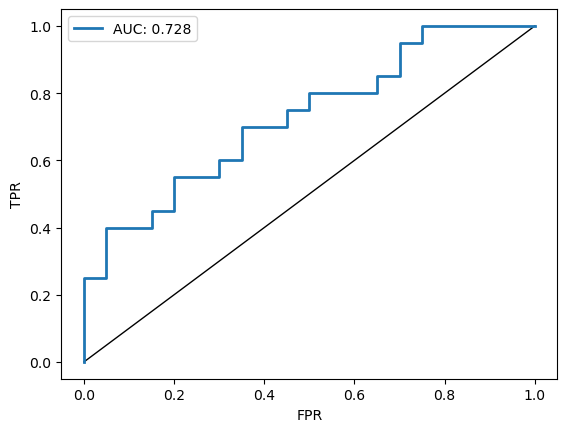

In [38]:
# plot the curve, we see that the attacker is much better than random guessing
import tensorflow_privacy.privacy.membership_inference_attack.plotting as plotting
print(plotting.plot_roc_curve(attacks_result.get_result_with_max_auc().roc_curve))